In [2]:
import torch
import pickle
import numpy as np
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.loader import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Load data splits
# dataset = 'fer2013'
dataset = 'ck'
train_data_path = dataset + '_data/train_data_70_20_10.pkl'
val_data_path = dataset + '_data/val_data_70_20_10.pkl'
test_data_path = dataset + '_data/test_data_70_20_10.pkl'

with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

adjacency_matrix = np.loadtxt('standard_mesh_adj_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adjacency_matrix)

# Add batch attribute to each data object
for data in train_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in val_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in test_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [15]:
from torch_geometric.nn import BatchNorm
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GraphConv

class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGCN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(hidden_dim)
        
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(hidden_dim)
        
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, data):
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        return global_mean_pool(x, batch)

In [62]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

def evaluate_xgb(model, train_loader, test_loader):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for idx, data in enumerate(train_loader):
        data = data.to(device)
        out = model.get_embeddings(data).cpu().detach().numpy()
        X_train.extend(out.tolist())
        y_train.extend(data.y.cpu().detach().numpy().tolist())
    
    for idx, data in enumerate(test_loader):
        data = data.to(device)
        out = model.get_embeddings(data).cpu().detach().numpy()
        X_test.extend(out.tolist())
        y_test.extend(data.y.cpu().detach().numpy().tolist())
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    #Creating an XGBoost classifier
    xgb_model = xgb.XGBClassifier()
    
    #Training the model on the training data
    xgb_model.fit(X_train, y_train)
    
    #Making predictions on the test set
    predictions = xgb_model.predict(X_test)
    
    #Calculating accuracy
    test_accuracy = accuracy_score(y_test, predictions)
    train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
    
    label_mapping = ['neutral', 'happiness', 'sadness', 'surprise', 'fear',
                     'disgust', 'anger', 'contempt']
    return test_accuracy, train_accuracy
    #print("\nClassification Report:")
    #print(classification_report(y_test, predictions, target_names=label_mapping))

In [56]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return total_loss / len(train_loader), correct / total

def evaluate(model, device, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
            val_loss += criterion(out, data.y).item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return correct / total, val_loss / len(loader), all_labels, all_preds


In [95]:
from sklearn.model_selection import ShuffleSplit


def run_cross_validation(all_data, 
                         device, 
                         n_epochs=501,
                         batch_size=32,
                         n_splits=20, 
                         test_size=0.25):
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    all_train_losses = []
    all_train_accuracies = []
    all_xgb_test_accuracies = []
    all_xgb_train_accuracies = []
    test_losses = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(splitter.split(all_data)):
        model = SimpleGCN(input_dim=3, hidden_dim=16, output_dim=output_dim).to(device)
        train_losses = []
        train_accuracies = []
        xgb_test_accuracies = []
        xgb_train_accuracies = []
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        train_data = [all_data[idx] for idx in train_index]
        test_data = [all_data[idx] for idx in test_index]
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        # Initialize model, optimizer, and criterion

        # Calculate class weights
        label_counts = np.bincount([data.y.item() for data in train_data])
        class_weights = 1.0 / label_counts
        class_weights = class_weights / class_weights.sum()
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        for epoch in range(n_epochs):
            train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc) 
        xgb_test_acc, xgb_train_acc = evaluate_xgb(model, train_loader, test_loader)
        xgb_train_accuracies.append(xgb_train_acc)
        xgb_test_accuracies.append(xgb_test_acc)
        test_acc, test_loss, test_labels, test_preds = evaluate(
            model, 
            device, 
            test_loader, 
            criterion
        )
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        print(f'Split: {i+1}/{n_splits}, Test Loss: {test_loss:.4f}, Test Acc: {int(100 * test_acc):02d}%')
        print(f'XGB Accuracy for Last epoch: {xgb_test_accuracies[-1]:.4f}')
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_xgb_train_accuracies.append(xgb_train_accuracies)
        all_xgb_test_accuracies.append(xgb_test_accuracies)
    return test_losses, test_accuracies, all_train_losses, all_train_accuracies, all_xgb_train_accuracies, all_xgb_test_accuracies

In [97]:
all_data = train_data + val_data + test_data
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
output_dim = len(np.unique([data.y.item() for data in train_data]))
test_losses, test_accuracies, all_train_losses, all_train_accuracies, all_xgb_train_accuracies, all_xgb_test_accuracies = run_cross_validation(
    all_data, 
    device, 
    n_epochs=30,
    n_splits=5
)

Split: 1/5, Test Loss: 1.8054, Test Acc: 41%
XGB Accuracy for Last epoch: 0.4667
Split: 2/5, Test Loss: 1.7183, Test Acc: 45%
XGB Accuracy for Last epoch: 0.5619
Split: 3/5, Test Loss: 1.9378, Test Acc: 31%
XGB Accuracy for Last epoch: 0.5714
Split: 4/5, Test Loss: 1.7809, Test Acc: 46%
XGB Accuracy for Last epoch: 0.5905
Split: 5/5, Test Loss: 1.8209, Test Acc: 42%
XGB Accuracy for Last epoch: 0.6095


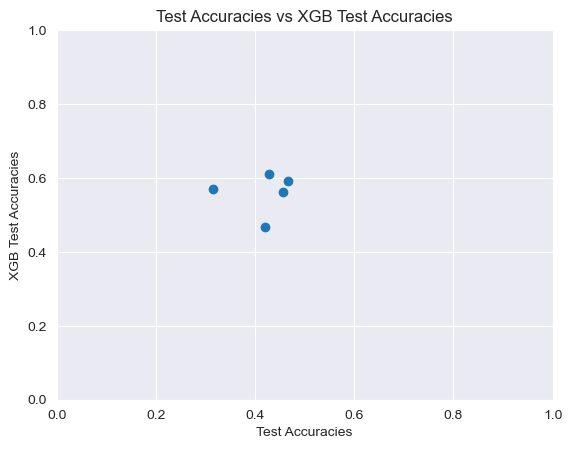

In [98]:
# Scatter plot for test_accuracies and xgb_test_accuracies
# Make the axes range from 0 to 1
xgb_acc = [ acc[-1] for acc in all_xgb_test_accuracies]
plt.xlabel('Test Accuracies')
plt.ylabel('XGB Test Accuracies')
plt.title('Test Accuracies vs XGB Test Accuracies')
plt.scatter(test_accuracies, xgb_acc)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

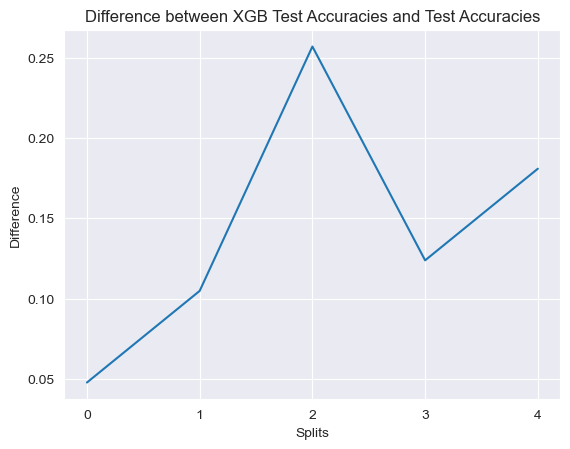

In [100]:
# Show difference between test accuracies and xgb test accuracies
diff = np.array(xgb_acc) - np.array(test_accuracies)
plt.plot(diff)
plt.xlabel('Splits')
plt.ylabel('Difference')
plt.title('Difference between XGB Test Accuracies and Test Accuracies')
plt.xticks(range(0, 5, 1))
plt.show()

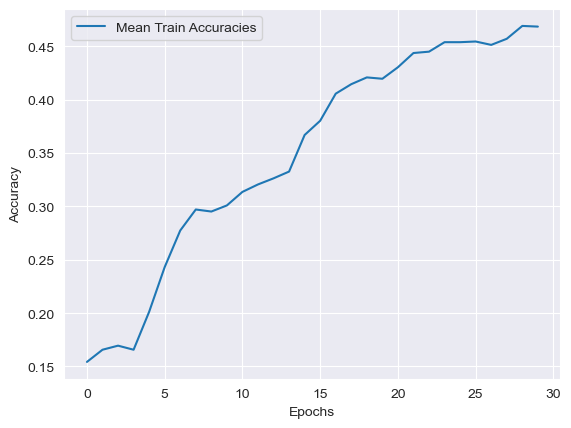

In [101]:
# Plot  mean train accuracies vs mean xgb accuracies
np_train_accuracies = np.array(all_train_accuracies)
mean_train_accuracies = np.mean(np_train_accuracies, axis=0)
plt.plot(mean_train_accuracies, label='Mean Train Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Don't use

Test Accuracy: 60.00%


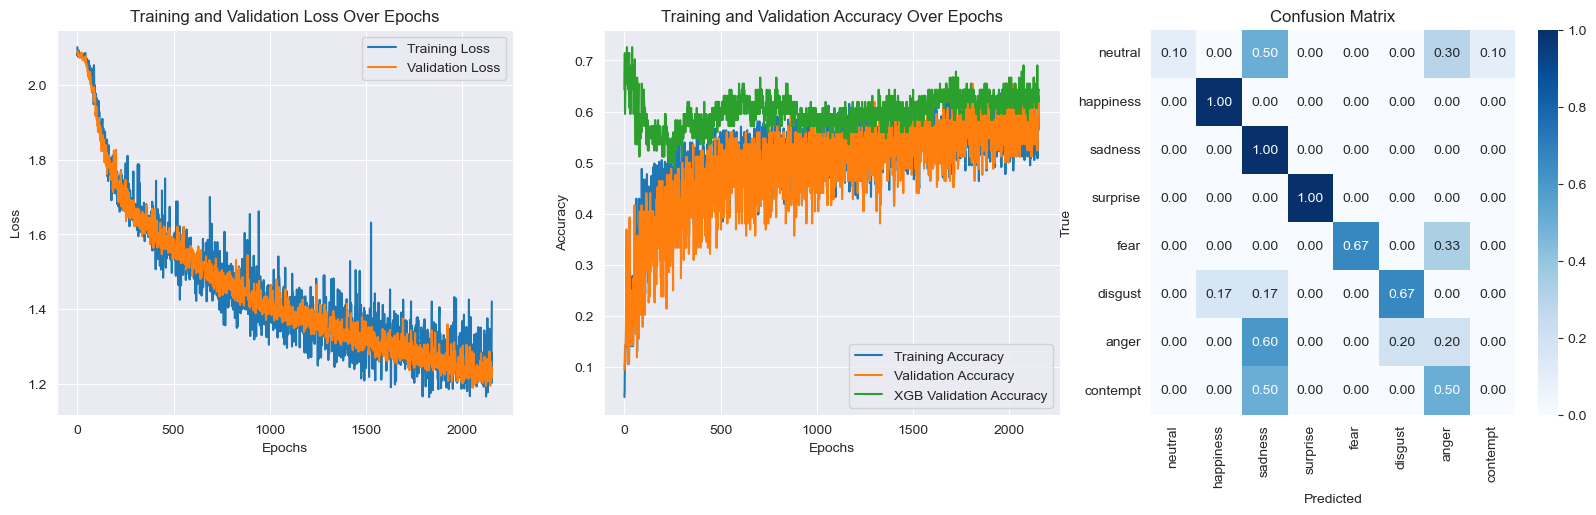

              precision    recall  f1-score   support

     neutral       1.00      0.10      0.18        10
   happiness       0.88      1.00      0.93         7
     sadness       0.23      1.00      0.38         3
    surprise       1.00      1.00      1.00         9
        fear       1.00      0.67      0.80         3
     disgust       0.80      0.67      0.73         6
       anger       0.17      0.20      0.18         5
    contempt       0.00      0.00      0.00         2

    accuracy                           0.60        45
   macro avg       0.63      0.58      0.52        45
weighted avg       0.77      0.60      0.58        45



In [13]:
# Evaluation on test set
test_acc, test_loss, test_labels, test_preds = evaluate(test_loader)
print(f'Test Accuracy: {100 * test_acc:.2f}%')

plt.figure(figsize=(20, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(xgb_accuracies, label='XGB Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

if dataset == 'ck':
    label_mapping = {'neutral': 0, 'happiness': 1, 'sadness': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'anger': 6, 'contempt': 7}
elif dataset == 'fer2013':
    label_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'angry': 6}
else:
    raise ValueError('Invalid dataset')
class_names = [name for name in label_mapping.keys()]

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds, normalize='true')
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(class_report)

In [36]:
len(test_labels)

45